## Introduction to the Simulation

Suppose we have two agents, one with marginal productivity $\theta^H$ and one with marginal productivity $\theta^L$ . $\theta^H > \theta^L$. Suppose there are $k$ conferences, and the difficulty of conference $j$ is denoted by $q_j$. 
The action is updated according to the following rule:

$a_{j, t+1}^i = \frac{(c_j^i)^{\frac{1}{\alpha-1}} \cdot \overline{\theta}_{j,t}^{\frac{\beta}{1-\alpha}}} {\sum_l (c_l^i)^{\frac{\alpha}{\alpha-1}} \cdot \overline{\theta}_{l,t}^{\frac{\beta}{1-\alpha}}}$

We assume the cost function takes the following form:

$c(q_j, \theta_i) = e^{q_j/\theta_i}$




In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import math as math
import random

In [29]:
''' take_cost_function: assume a specific cost format
    Input:
        - theta: marginal productivity of a researcher
        - diff_lst: the difficulty list of all conferences
        - conf_index: the index of the conference
    Output:
        - cost: amount of cost
'''
def take_cost_function(theta, diff_lst, conf_index):
    diff = diff_lst[conf_index]
    ## calculate the cost function according to the specified format
    cost = math.exp(diff/theta)
    return cost

In [30]:
''' take_quality_one_conf: calculate the quality on a single conference
        Input:
            - action_H: the action list(vector) of agent H
            - action_L: the action list(vector) of agent L
            - index: the index of the conference
            - theta_H: the marginal productivity of H type researcher
            - theta_L: the marginal productivity of L type researcher
        Output:
            - quality: the quality of a single conference
'''
def take_quality_one_conf(action_H, action_L, index, theta_H, theta_L):
    ## H_index is the action of H on the conference with specified index
    H_index = action_H[index] 
    ## L_index is the action of L on the conference with specified index
    L_index = action_L[index]
    ## Take the average
    quality = (H_index * theta_H + L_index * theta_L)/(H_index + L_index)                                
    return quality

In [46]:
''' take_quality_all_conf: calculate the quality on all conferences
        Input:
            - action_H: the action list(vector) of agent H
            - action_L: the action list(vector) of agent L
            - k is the number of conferences,
            - theta_H: the productivity of H type researcher
            - theta_L: the productivity of L type researcher
        Output:
            - quality_vec: the quality vector of all conferences
'''
def take_quality_all_conf(action_H, action_L, k, theta_H, theta_L):
    quality_lst = []
    for index in range(0, k):
        ## calculate the quality on one conference
        quality_one_conf = take_quality_one_conf(action_H, action_L, index, theta_H, theta_L)
        ## synthesize the information from all conferences
        quality_lst.append(quality_one_conf)
    return quality_lst

In [32]:
''' check_equilibrium: calculate the distance between the previous quality
    vector and the current quality vector

    Input:
    - prev_qual: the quality vector from the last round
    - qual: the quality vector of this round

    Output:
    - dist: the distance between the quality vector from the last round 
    and this round
'''

def check_equilibrium(prev_qual, qual):
    if len(prev_qual) != len(qual):
        raise ValueError("Vectors must be of the same length.")
    ## calculate the distance between the previous quality vector
    ## and the current quality vector
    dist = math.sqrt(sum((a - b) ** 2 for a, b in zip(prev_qual, qual)))
    return dist

In [60]:
''' update_action: calculate the action on a single conference for the next 
    round given the new quality information
    Input:
        - quality_lst: the quality of all conferences
        - index: the index of the conference
        - theta: the productivity of the researcher
        - alpha, beta: parameter that specifies a researcher
        - diff_list: the difficulty list of conferences
    Output:
        - action_one_conf: the action of a researcher on one conference
'''

def update_action_one_conf(quality_lst, index, theta, alpha, beta, diff_lst):

    ## update the action according to the action formula
    
    cost = take_cost_function(theta, diff_lst, index)

    numer = (cost ** (1/(alpha-1))) ** (quality_lst[index] ** (beta/(1-alpha)))

    denom = 0
    for l in range(len(diff_lst)):
        cost_l = take_cost_function(theta,diff_lst, l)
        denom += ((cost_l) ** (alpha/(alpha-1))) * (quality_lst[l] ** (beta/(1-alpha)))
    
    if denom != 0:
        action_one_conf = numer/denom

    return action_one_conf

In [61]:
''' update_action_all_conf: calculate the action on all conferences for the next 
    round given the new quality information

    Input:
        - quality_lst: the quality of all conferences
        - theta: the productivity of the researcher
        - alpha, beta: parameter that specifies a researcher
        - diff_list: the difficulty list of conferences
    Output:
        - cost: the action of a researcher on allconference
'''

def update_action_all_conf(quality_lst, theta, alpha, beta, diff_lst):
    ## update the action of a researcher on all conferences
    action_lst = []
    for l in range(len(diff_lst)):
        action_one_conf = update_action_one_conf(quality_lst, l, theta, alpha, beta, diff_lst)
        action_lst.append(action_one_conf)
    return action_lst

In [62]:
''' randomize_first_round: randomize the researcher's action on all conferences
    for the first round of the paper publication game
    Input:
        - diff_list: the difficulty list of conferences
        - theta: marginal productivity of a researcher
        - budget: budget is 1
    Output:
        - action_lst: the action of the researcher on all conferences
'''

def randomize_first_round(diff_lst, theta, budget = 1):
    cost_lst = []
    for l in range(len(diff_lst)):
        cost_one_conf = take_cost_function(theta, diff_lst, l)
        cost_lst.append(cost_one_conf)
        
    ## randomize researcher's action on all conferences
    random_action = [random.uniform(0, 10) for _ in range(10)]

    ## The overall cost
    overall_cost = 0
    for l in range(len(random_action)):
        overall_cost += random_action[l] * cost_lst[l]

    scale_factor = overall_cost/budget

    ## scale the action so that it exhausts the budget
    action_lst = []
    for l in range(len(random_action)):
        action_lst.append(random_action[l]/scale_factor)

    return action_lst

In [100]:
''' game_init: initialize a game after specifying certain parameters, stop
    if the game has already converged to the equilibrium

    Input:
        - diff_lst: the difficulty level of all conferences
        - theta_H: the productivity level of H type researcher
        - theta_L: the productivity level of L type researcher
        - alpha, beta: parameter for researchers 
        - k: the number of conferences

    Output:
        - qual: the quality vector of all conferences
        - action_H: the action of H type researcher
        - action_L: the action of L type researcher
'''

def game_init(diff_lst, theta_H, theta_L, alpha, beta, k, display = False):
    prev_qual = []
    qual = []
    qual_dist  = 1

    ## init first round
    action_H = randomize_first_round(diff_lst, theta_H)
    action_L = randomize_first_round(diff_lst, theta_L)
    qual = take_quality_all_conf(action_H, action_L, k, theta_H, theta_L)

    qual_dist_lst = []
    round_lst = []
    action_H_lst = []
    action_L_lst = []
    i = 0
    

    while (qual_dist > 0.00001):
        prev_qual = qual
        i += 1 

        action_H = update_action_all_conf(qual, theta_H, alpha, beta, diff_lst)
        action_L = update_action_all_conf(qual, theta_L, alpha, beta, diff_lst)
        qual = take_quality_all_conf(action_H, action_L, k, theta_H, theta_L)
        qual_dist = check_equilibrium(prev_qual, qual)

        qual_dist_lst.append(qual_dist)
        round_lst.append(i)
        action_H_lst.append(action_H)
        action_L_lst.append(action_L)

    if (display):
        # Customize the plot 
        plt.plot(round_lst, qual_dist_lst, label='Distance between quality vectors')
        plt.title('Evolution of the paper publication Game')
        plt.xlabel('Round Number')
        plt.ylabel('Quality vector difference')
        plt.legend()  # Show legend

        # Show the plot
        plt.show()

    return qual, action_H, action_L

In [91]:
''' sum_action: sum the action of a researcher
    Input:
        -action_lst: the action of a researcher across conferences
    Output:
        -sum of action
'''
def sum_action(action_lst):
    sum = 0
    for i in action_lst:
        sum += i

    return sum

In [92]:
''' find_low_type_publish_more: find a low marginal productivity researcher
    who publishes more than the high type marginal productivity researcher

    Input:
        - theta_H: the productivity level of H type researcher
        - theta_L: the productivity level of L type researcher
        - low_diff: the difficulty level of the easiest conference
        - high_diff: the difficulty level of the hardest conference
        - k: number of conferences

    Output:
        - qual: the quality vector of all conferences
        - action_H: the action of H type researcher
        - action_L: the action of L type researcher
'''

def find_low_type_publish_more(theta_H, theta_L, low_diff, high_diff, k, max_iter = 3000):
    i = 0

    low_diff = 0.1
    high_diff = 0.5
    k = 10 # number of conferences

    # Generate the difficulty level of all conferences
    diff_lst = np.linspace(low_diff, high_diff, k).tolist()

    while (i < max_iter):

        alpha = random.uniform(0.2, 0.5)  
        beta = random.uniform(1.1, 3)  

        qual, action_H, action_L = game_init(diff_lst, theta_H, theta_L, alpha, beta, k)

        ## print all the information of the game if 
        ## the low type publishes more than the high type
        if (sum_action(action_L) > sum_action(action_H)):
            print("Special case")
            print(f"The alpha value is {alpha}")
            print(f"The beta value is {beta}")
            print(f"The theta_H value is {theta_H}")
            print(f"The theta_L value is {theta_L}")
            print(f"The action chosen by H is {action_H}")
            print(f"The action chosen by L is {action_L}")
            return
        i += 1
    print("find nothing")

In [87]:
## Low Type Who Publishes More than the High Type
find_low_type_publish_more(3, 0.1, 0.1, 0.5, 10)

Special case
The alpha value is 0.4518168102803746
The beta value is 2.2477741884584246
The theta_H value is 3
The theta_L value is 0.1
The action chosen by H is [5.475570979487108e-06, 0.0013339158767118732, 4.123837401667052e-08, 3.5788013563414537e-09, 3.1058011993812673e-10, 2.6953161490749614e-11, 2.339083758777423e-12, 2.0299336062873257e-13, 1.761642964033266e-14, 1.5288115449273128e-15]
The action chosen by L is [2.2432360077563527e-74, 0.008950469696689538, 4.539819348776861e-138, 6.4583320994624494e-170, 9.18760203931689e-202, 1.3070252494424704e-233, 1.859369828351361e-265, 2.6451334127314374e-297, 0.0, 0.0]


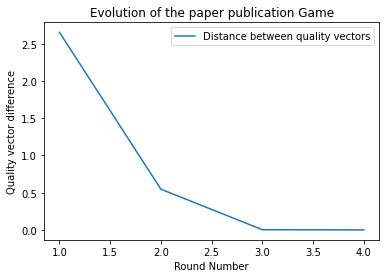

([3.3397799445556533,
  3.3399962231373297,
  3.339999935031455,
  3.3399999988823654,
  3.3399999999807735,
  3.3399999999996695,
  3.339999999999994,
  3.34,
  3.34,
  3.34],
 [5.108087992006063e-07,
  1.8579379946127165e-08,
  6.770770085974828e-10,
  2.467548536318428e-11,
  8.992776434476882e-13,
  3.277343023493523e-14,
  1.1944005699262728e-15,
  4.352894131699841e-17,
  1.5863762793548356e-18,
  5.781417198669933e-20],
 [6.109766421617423e-11,
  3.813690793230239e-14,
  2.39069073920881e-17,
  1.49881352916566e-20,
  9.396645105020362e-24,
  5.891122671490731e-27,
  3.693374175362238e-30,
  2.315520073198416e-33,
  1.451689689377583e-36,
  9.101207882574742e-40])

In [99]:
low_diff = 0.1
high_diff = 0.5
k = 10 # number of conferences

# Generate the difficulty level of all conferences
diff_lst = np.linspace(low_diff, high_diff, k).tolist()
theta_H = 3.34
theta_L = 1.5
alpha = 0.5
beta = 2

game_init(diff_lst, theta_H, theta_L, alpha, beta, k, display = True)